# Stage1 
 

## Normalize and embed + HDBSCAN + LLM for campaign name

In [2]:
import os
from params import DATA_DIR

# ------------------------------------------------------------------
# Run-specific config (CHANGE ONLY ORIGINATOR)
# ------------------------------------------------------------------
ORIGINATOR = "24273"      # change this for each run

# Directories
data_dir = DATA_DIR
input_dir = os.path.join(data_dir, "input")
output_dir = os.path.join(data_dir, "output")

# Ensure output dir exists
os.makedirs(output_dir, exist_ok=True)

# Input CSV: ref_<ORIGINATOR>.csv
REF_CSV = os.path.join(input_dir, f"ref_{ORIGINATOR}.csv")

# Output prefix (all output files will start with this)
RUN_PREFIX = ORIGINATOR

# New batch CSV (Stage 2)
NEW_INPUT_PREFIX = "mixed_160_orig__40_new"      # or f"new_{ORIGINATOR}"
NEW_BATCH_CSV = os.path.join(input_dir, f"{NEW_INPUT_PREFIX}.csv")

print("REF_CSV       :", REF_CSV)
print("NEW_BATCH_CSV :", NEW_BATCH_CSV)
print("Output folder :", output_dir)


REF_CSV       : ./data\input\ref_24273.csv
NEW_BATCH_CSV : ./data\input\mixed_160_orig__40_new.csv
Output folder : ./data\output


In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["LAPTOP_ID"] = "LAPTOP_A"  # or B

from params import (
    LOCAL_MODEL,
    HDBSCAN_STAGE1,
    adaptive_hdbscan_params,
)

from ref_data_helpers import (
    build_reference_embeddings_from_csv,
    build_reference_profile,
)

# ----------------------------------------------------------
# Stage 1a: build reference prototypes + embeddings
# ----------------------------------------------------------
meta_df, X = build_reference_embeddings_from_csv(
    csv_path=REF_CSV,
    data_dir=output_dir,
    prefix=RUN_PREFIX,
    text_col="raw_text",
    model_path=LOCAL_MODEL,
)

# Adaptive HDBSCAN params based on data size
n_stage1 = len(X)
hdbscan_params_stage1 = adaptive_hdbscan_params(
    HDBSCAN_STAGE1,
    n_points=n_stage1,
    min_cluster_frac=0.02,   # e.g. 2% for reference campaigns
)
print("Stage 1 HDBSCAN params:", hdbscan_params_stage1)

# ----------------------------------------------------------
# Stage 1b: cluster prototypes into reference campaigns
# ----------------------------------------------------------
campaigns_df, examples_df, C = build_reference_profile(
    data_dir=output_dir,
    prefix=RUN_PREFIX,
    hdbscan_params=hdbscan_params_stage1, #HDBSCAN_STAGE1,
)


.env loaded from: C:\Users\ee7823\OneDrive - AT&T Services, Inc\Documents\campaign_drift\.env
[Stage 1] rows = 200; prototypes = 37
[Stage 1] Saved embeddings to: ./data\output\24273.csv, ./data\output\24273.npy
Stage 1 HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 1, 'cluster_selection_epsilon': 0.0, 'cluster_selection_method': 'eom', 'metric': 'euclidean'}
[HDBSCAN] Using parameters:
  min_cluster_size = 5
  min_samples = 1
  cluster_selection_epsilon = 0.0
  cluster_selection_method = eom
  metric = euclidean
[Stage 1] HDBSCAN: total=37, noise=2, clusters=5


c:\Users\ee7823\OneDrive - AT&T Services, Inc\Documents\campaign_drift\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ee7823\OneDrive - AT&T Services, Inc\Documents\campaign_drift\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Saved artifacts:
 - campaigns_csv: ./data\output\24273_campaigns.csv
 - centroids_npy: ./data\output\24273_campaign_centroids.npy
 - campaign_examples_csv: ./data\output\24273_campaign_examples.csv
[Stage 1] Reference build complete. Saved artifacts for prefix=24273 under ./data\output


# Stage 2 

## Normalize new data and embed + Assing to ref centroids + Look for new campaigns

In [5]:
from new_data_helpers import (
    assign_new_batch_to_reference,
    cluster_unknown_prototypes,
    export_new_campaigns,
)

from params import (
    LOCAL_MODEL,
    SIM_THRESHOLD,
    HDBSCAN_UNKNOWN_DEFAULT,
    adaptive_hdbscan_params,
)


# ----------------------------------------------------------
# Stage 2a: assign new messages to existing campaigns
# ----------------------------------------------------------
new_meta_df, new_X = assign_new_batch_to_reference(
    data_dir=output_dir,        # <-- reference files live here now
    ref_prefix=RUN_PREFIX,      # 24273
    new_batch_csv=NEW_BATCH_CSV,
    sim_threshold=SIM_THRESHOLD,
    model_path=LOCAL_MODEL,
    seed=0,
    verbose=True,
)

# Adaptive HDBSCAN params based on number of Unknowns
if "status" in new_meta_df.columns:
    n_unknown = new_meta_df["status"].astype(str).str.lower().eq("unknown").sum()
else:
    n_unknown = len(new_meta_df)

hdbscan_params_stage2 = adaptive_hdbscan_params(
    HDBSCAN_UNKNOWN_DEFAULT,
    n_points=int(n_unknown),
    min_cluster_frac=0.01,   # e.g. 1% for Unknowns
)
print("Stage 2 (Unknown) HDBSCAN params:", hdbscan_params_stage2)



# ----------------------------------------------------------
# Stage 2b: cluster unknowns
# ----------------------------------------------------------
upserted_meta_df, proposed_clusters = cluster_unknown_prototypes(
    data_dir=output_dir,
    ref_prefix=RUN_PREFIX,
    hdbscan_params=hdbscan_params_stage2, #HDBSCAN_UNKNOWN_DEFAULT,
    verbose=True,
)

# ----------------------------------------------------------
# Stage 2c: export proposed new campaigns
# ----------------------------------------------------------
new_campaigns_df = export_new_campaigns(
    data_dir=output_dir,
    ref_prefix=RUN_PREFIX,
    meta_df=upserted_meta_df,
    proposed_clusters=proposed_clusters,
    verbose=True,
)

[Stage 2a] New batch rows = 200; dedup prototypes = 44
[Stage 2a] Saved new prototypes meta to: ./data\output\24273_new_prototypes.csv
[Stage 2a] Saved new prototypes embeddings to: ./data\output\24273_new_prototypes.npy
Stage 2 (Unknown) HDBSCAN params: {'min_cluster_size': 5, 'min_samples': 2, 'metric': 'euclidean'}
[Stage 2b] Total prototypes: 44, Known: 30, coverage=0.682
[Stage 2b] Unknown prototypes: 14
[Stage 2b] Running HDBSCAN on 14 unknown prototypes...
[Stage 2b] HDBSCAN labels (label, count): [(-1, 1), (0, 8), (1, 5)]
Found cluster 0 size=8 proposed_label='' (top-5 sent to LLM)
Found cluster 1 size=5 proposed_label='' (top-5 sent to LLM)
[Stage 2b] Saved updated prototype assignments with proposed clusters to: ./data\output\24273_new_prototypes_assignments_upserted.csv

[Stage 2b] Proposed clusters summary:
 - cluster 0: size=8, proposed_label=''
 - cluster 1: size=5, proposed_label=''

[Stage 2c] Exporting new campaigns to reference format...
[Stage 2c] Saved 2 new campaig

c:\Users\ee7823\OneDrive - AT&T Services, Inc\Documents\campaign_drift\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ee7823\OneDrive - AT&T Services, Inc\Documents\campaign_drift\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# Stage 3. Results

In [14]:
import os
import pandas as pd

from params import DATA_DIR

# ---- Paths (match Stage-1/2 artifacts in data/output) ----
REF_CAMPAIGNS_CSV = os.path.join(output_dir, f"{RUN_PREFIX}_campaigns.csv")
PROTO_META_CSV    = os.path.join(output_dir, f"{RUN_PREFIX}_new_prototypes.csv")
NEW_CAMPAIGNS_CSV = os.path.join(output_dir, f"{RUN_PREFIX}_new_campaigns.csv")

# ---- Load data ----
ref_campaigns_df = pd.read_csv(REF_CAMPAIGNS_CSV, encoding="utf-8")
meta_df = pd.read_csv(PROTO_META_CSV, encoding="utf-8")

# Detect optional columns
weight_col = "count_in_window" if "count_in_window" in meta_df.columns else None
status_col = "status" if "status" in meta_df.columns else None

# ---- Compute coverage (prototype-level) ----
if status_col:
    known_mask_full = meta_df[status_col].astype(str).str.lower().eq("known")
    coverage = known_mask_full.mean()
else:
    coverage = None

# ---- Count new messages assigned to reference campaigns ----
if status_col:
    known_mask = meta_df[status_col].eq("Known")
else:
    # if no status column, treat all as Known for this summary
    known_mask = pd.Series(True, index=meta_df.index)

assigned = meta_df[known_mask & meta_df["assigned_campaign_row_index"].notna()]

if weight_col:
    ref_counts = assigned.groupby("assigned_campaign_row_index")[weight_col].sum()
else:
    ref_counts = assigned.groupby("assigned_campaign_row_index").size()

# ---- Rows for reference campaigns ----
ref_rows = [
    {
        "Ref_Campaign_name": row.campaign_name,
        "Count": getattr(row, "proto_count", getattr(row, "prototypes_count", 0)),
        "New_Cluster_name": row.campaign_name,  # existing campaigns keep same name
        "New_number_assigned": int(ref_counts.get(int(row.row_index), 0)),  # type: ignore
    }
    for row in ref_campaigns_df.itertuples(index=False)
]

# ---- Rows for *new* clusters (if exist) ----
new_rows = []
if os.path.exists(NEW_CAMPAIGNS_CSV):
    nc = pd.read_csv(NEW_CAMPAIGNS_CSV, encoding="utf-8")
    count_col = next((c for c in ("msg_count", "proto_count") if c in nc.columns), None)

    new_rows = [
        {
            "Ref_Campaign_name": "NA",
            "New_Cluster_name": row.campaign_name,
            "New_number_assigned": int(getattr(row, count_col)) if count_col else 0,
        }
        for row in nc.itertuples(index=False)
    ]

# ---- Final summary ----
summary_df = pd.DataFrame(ref_rows + new_rows)

summary_df = summary_df.sort_values(
    by=["Ref_Campaign_name", "New_Cluster_name"],
    key=lambda col: (col == "NA") if col.name == "Ref_Campaign_name" else col,
).reset_index(drop=True)

print("Coverage =", coverage)
summary_df


Coverage = 0.6818181818181818


,Ref_Campaign_name,Count,New_Cluster_name,New_number_assigned
0,Appointment Confirmation And Reminders,6.0,Appointment Confirmation And Reminders,0
1,flash sale and discounts,6.0,flash sale and discounts,7
2,loan offers and approvals,5.0,loan offers and approvals,5
3,login verification messages,7.0,login verification messages,7
4,package delivery notification,11.0,package delivery notification,11
5,NA,NaN,flight updates and notifications,5
6,NA,NaN,mobile boarding pass reminders,8


## Plot UMAP of reference

In [ ]:
import os
from typing import Any, Dict

import joblib
import umap.umap_ as umap
import hdbscan

from sms_embed import load_embeddings
from ref_data_helpers import _get_hdbscan_defaults   # uses same HDBSCAN params as Stage 1
from plots import plot_campaigns

# Make sure these match your Stage-1 cell
ART_DIR = "./data/output"
REF_PREFIX = "ref_proto"   # same prefix you passed to build_reference_*


# -----------------------------
# 1) Load embeddings from disk
# -----------------------------
meta, X = load_embeddings(out_dir=ART_DIR, prefix=REF_PREFIX, encoding="utf-8")

print(f"Loaded embeddings: X.shape = {X.shape}, meta.shape = {meta.shape}")

# -----------------------------
# 2) Recompute HDBSCAN labels
#    (same params as Stage 1)
# -----------------------------
hdbscan_params = _get_hdbscan_defaults()
print("[DEBUG] HDBSCAN params for plotting:", hdbscan_params)

clusterer = hdbscan.HDBSCAN(**hdbscan_params)
labels = clusterer.fit_predict(X)

print(
    f"[DEBUG] HDBSCAN for plot: total={len(labels)}, "
    f"noise={(labels == -1).sum()}, clusters={len(set(labels) - {-1})}"
)

# -----------------------------
# 3) UMAP → 2D
# -----------------------------
UMAP_PARAMS: Dict[str, Any] = dict(
    n_neighbors=50,
    min_dist=0.05,
    metric="cosine",
    random_state=42,
    force_approximation_algorithm=False,
    transform_seed=42,
    densmap=False,
)

umap_model = umap.UMAP(**UMAP_PARAMS)
X_2d = umap_model.fit_transform(X)
joblib.dump(umap_model, os.path.join(ART_DIR, "umap_model.pkl"))

plot_path = os.path.join(ART_DIR, "umap_hdbscan_campaigns.png")

# -----------------------------
# 4) Prepare labels / names
#    campaigns_df is already in memory from Stage 1
# -----------------------------
# keep the same cluster ID order you use elsewhere (row_index order)
cluster_ids = campaigns_df.sort_values("row_index")["cluster_label"].tolist()

# map cluster_id -> LLM campaign_name (fallback to empty string)
campaign_name_map = dict(
    zip(
        campaigns_df["cluster_label"],
        campaigns_df["campaign_name"].fillna("").str.strip()
    )
)

names_list = [campaign_name_map.get(c, "") for c in cluster_ids]

# -----------------------------
# 5) Plot
# -----------------------------
plot_campaigns(X_2d, labels, cluster_ids, plot_path, campaign_names=names_list)
print(" - plot          :", plot_path)


# debug plot of new data

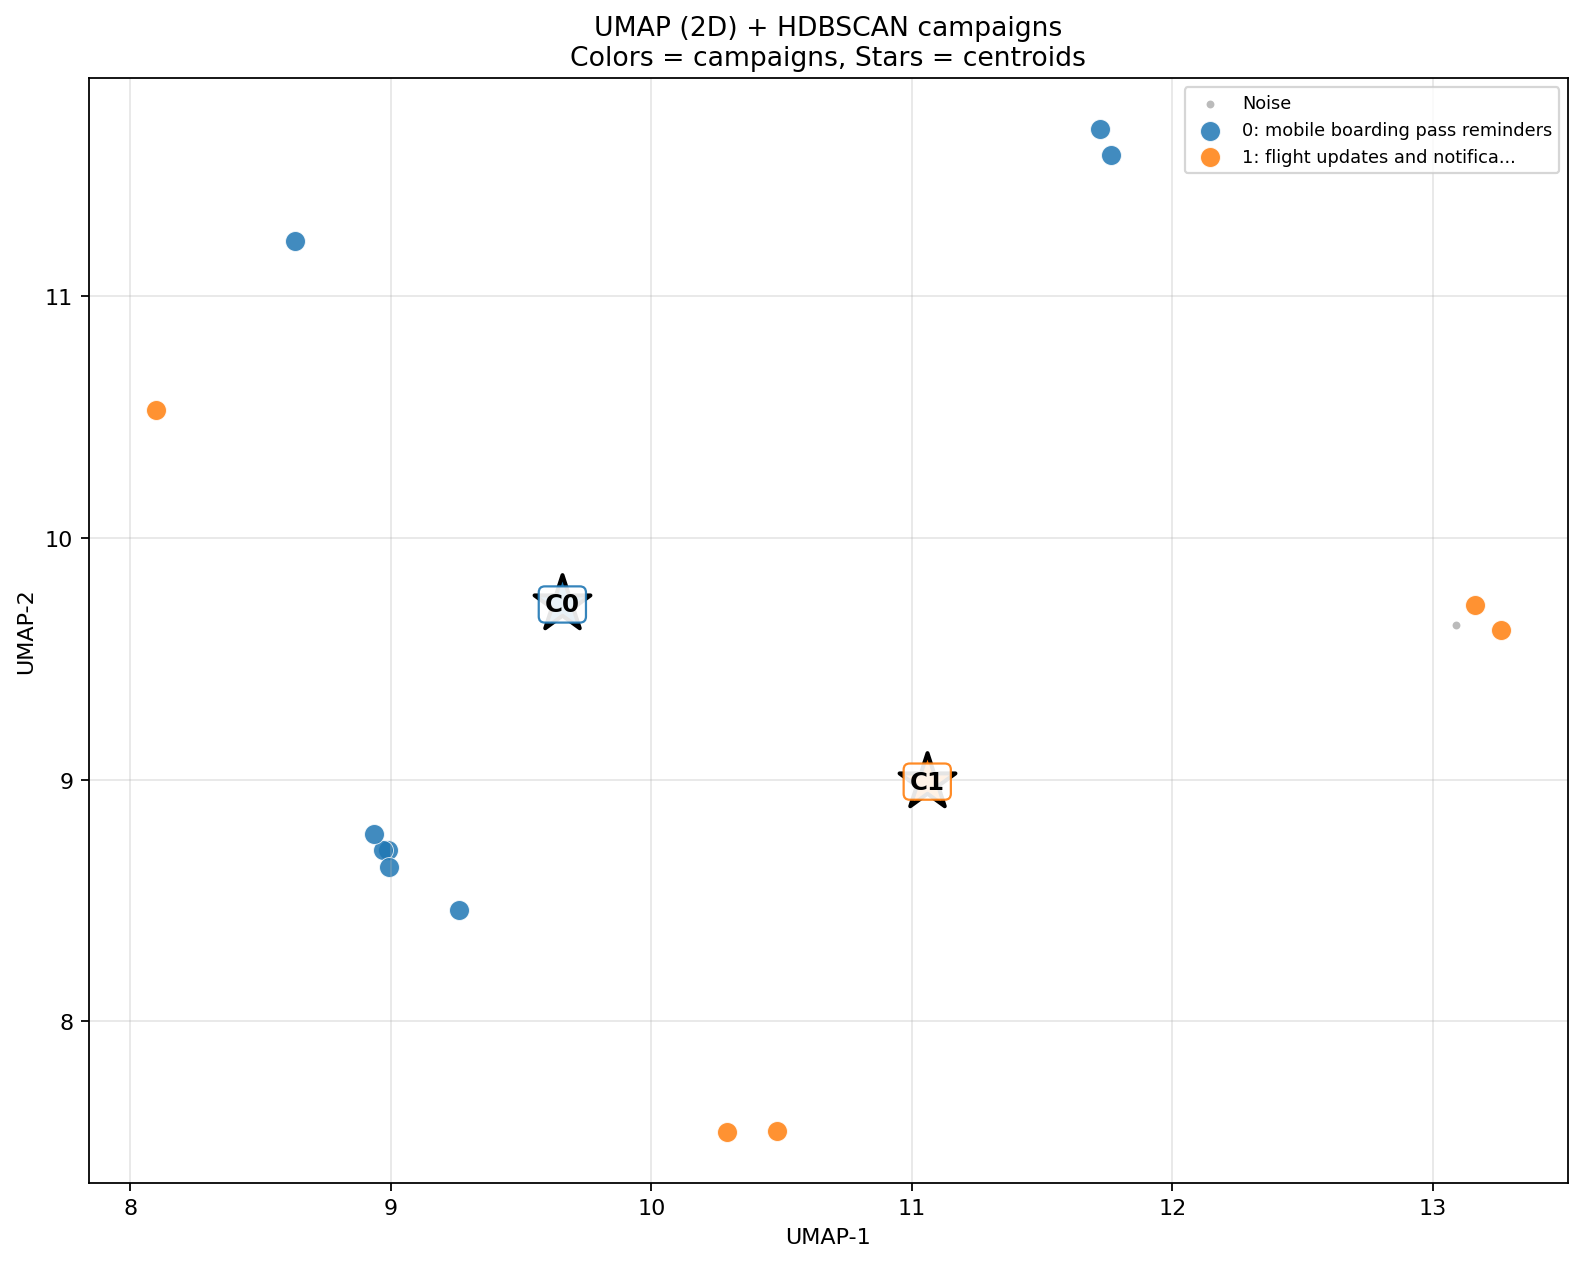

 - plot (unknown): ./data\output/ref_proto_umap_unknown_campaigns.png


In [9]:
import os
import numpy as np
import pandas as pd
import joblib

from params import DATA_DIR, OUTPUT_PREFIX
from plots import plot_campaigns

# 1) Load UMAP model trained in Stage-1 (on reference prototypes)
umap_model_path = os.path.join(DATA_DIR, "output", "umap_model.pkl")
umap_model = joblib.load(umap_model_path)

# 2) Load embeddings + meta for NEW prototypes
proto_npy_path = os.path.join(DATA_DIR, f"{OUTPUT_PREFIX}_new_prototypes.npy")
proto_meta_csv = os.path.join(DATA_DIR, f"{OUTPUT_PREFIX}_new_prototypes.csv")

X_all = np.load(proto_npy_path).astype(np.float32)

# Prefer the in-memory upserted_meta_df from Stage 2b, else reload
if "upserted_meta_df" in locals():
    meta_df_plot = upserted_meta_df.copy()
else:
    meta_df_plot = pd.read_csv(proto_meta_csv, encoding="utf-8")

# 3) Identify unknown prototypes
if "status" not in meta_df_plot.columns:
    raise ValueError("meta_df is missing 'status' column; cannot identify Unknown prototypes.")

status_series = meta_df_plot["status"].astype(str).str.lower()
known_mask = status_series.eq("known")
unknown_idx = np.where(~known_mask)[0]

if len(unknown_idx) == 0:
    print("[Plot Unknown] No Unknown prototypes to plot.")
else:
    X_unknown = X_all[unknown_idx]
    X_unknown_2d = umap_model.transform(X_unknown)

    # 4) Reconstruct labels_unknown from proposed_clusters
    #    (cluster_unknown_prototypes stored member_global_indices per cluster)
    labels_unknown = np.full(len(unknown_idx), -1, dtype=int)
    global_to_unknown_pos = {int(g): i for i, g in enumerate(unknown_idx)}

    for pc in proposed_clusters:
        cluster_label = int(pc["cluster_label"])
        for gi in pc["member_global_indices"]:
            pos = global_to_unknown_pos.get(int(gi))
            if pos is not None:
                labels_unknown[pos] = cluster_label

    # HDBSCAN cluster IDs (excluding noise -1)
    cluster_ids_unknown = sorted({int(l) for l in labels_unknown if l != -1})

    # 5) Build campaign-name map from LLM proposals
    proposed_name_map = {
        int(pc["cluster_label"]): (pc["proposed_label"] or "").strip()
        for pc in proposed_clusters
    }

    # 6) Plot
    unknown_plot_path = os.path.join(
        DATA_DIR, f"{OUTPUT_PREFIX}_umap_unknown_campaigns.png"
    )

    plot_campaigns(
        X_2d=X_unknown_2d,
        labels=labels_unknown,          # cluster labels over unknown subset
        cluster_ids=cluster_ids_unknown,
        save_path=unknown_plot_path,
        campaign_names=proposed_name_map,  # legend: "<cluster_id>: <LLM name>"
    )

    print(" - plot (unknown):", unknown_plot_path)


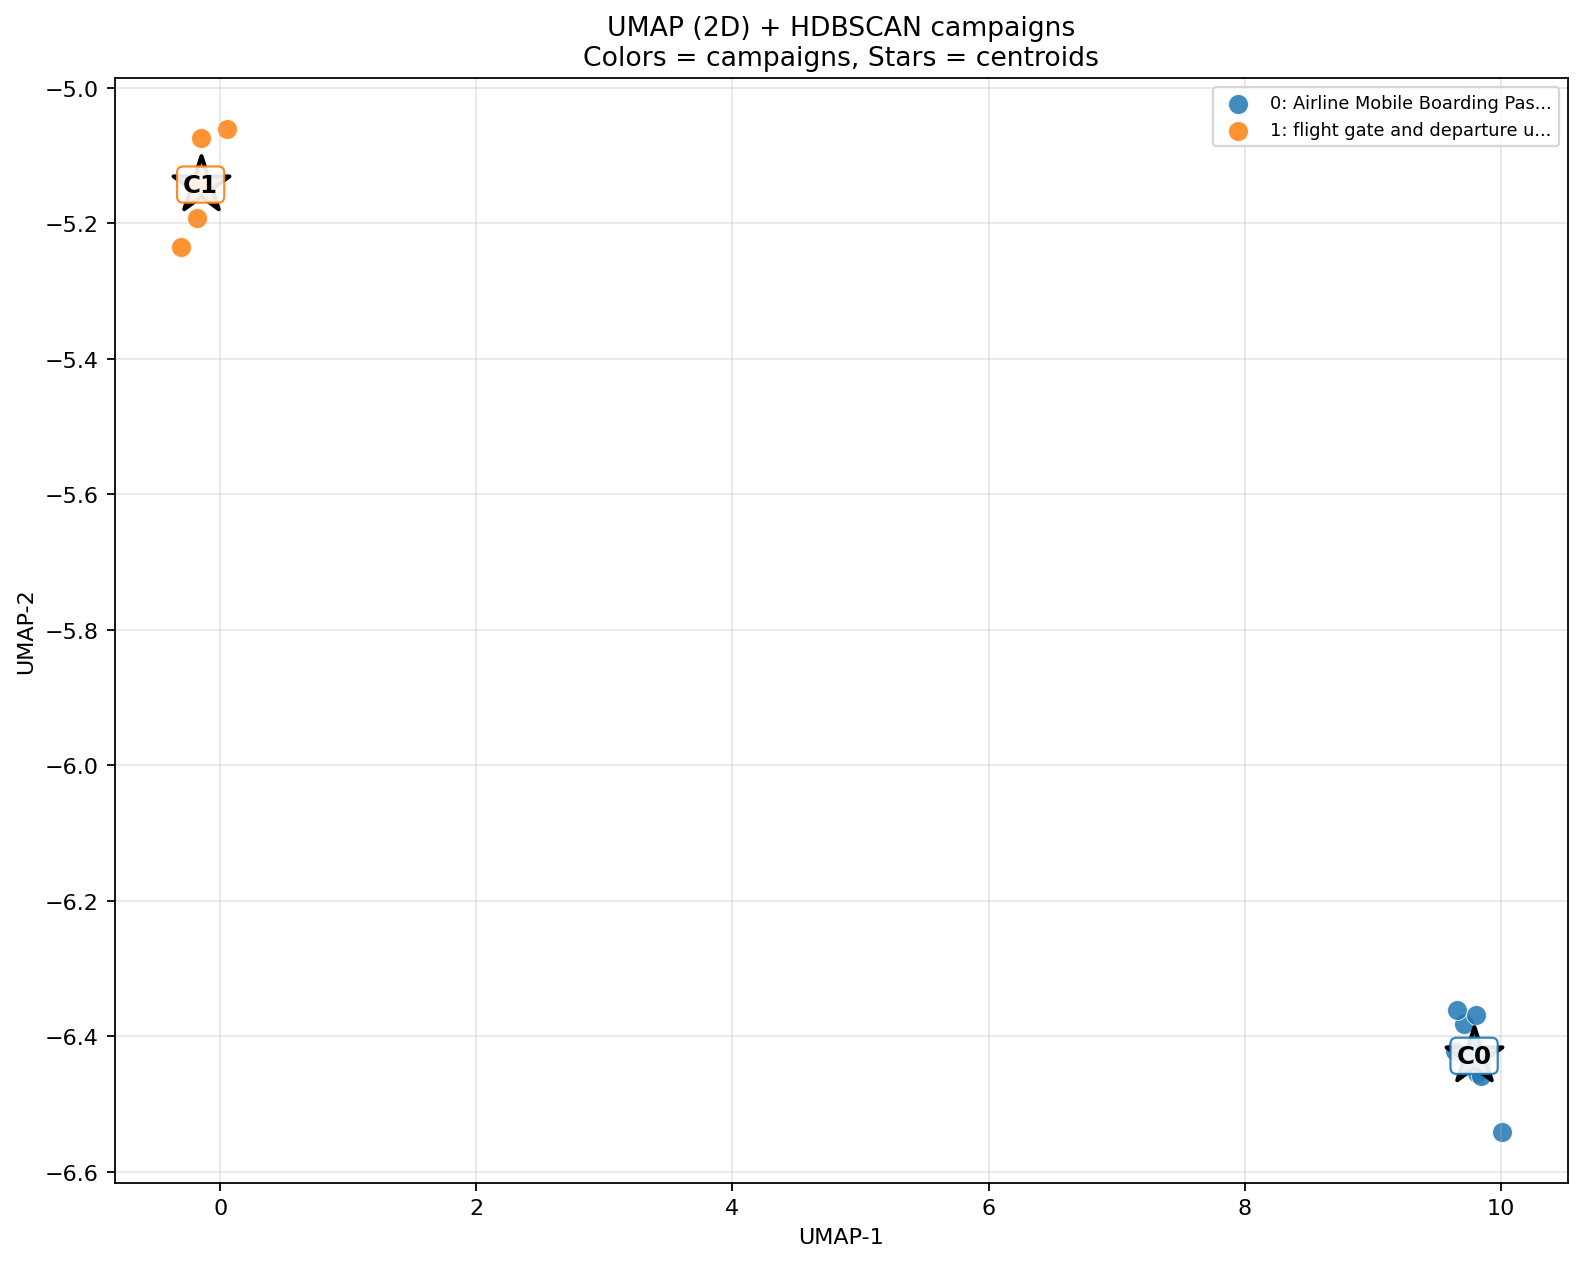

 - plot (unknown): ./artifacts\umap_unknown_campaigns.png


In [ ]:
# 1) 2D coords for the unknown prototypes
umap_model = joblib.load(os.path.join(ART_DIR, "umap_model.pkl"))


X_unknown = X[unknown_idx]  
X_unknown_2d = umap_model.transform(X_unknown)

# 2) Build cluster_ids (exclude -1 noise)
cluster_ids_unknown = sorted([int(l) for l in np.unique(labels_unknown) if l != -1])

# 3) Build campaign-name map from LLM proposals
proposed_name_map = {}
for pc in proposed_clusters:
    proposed_name_map[int(pc["cluster_label"])] = (pc["proposed_label"] or "").strip()

# 4) Plot
unknown_plot_path = os.path.join(ART_DIR, "umap_unknown_campaigns.png")
plot_campaigns(
    X_2d=X_unknown_2d,
    labels=labels_unknown,                  # HDBSCAN labels over unknown subset
    cluster_ids=cluster_ids_unknown,
    save_path=unknown_plot_path,
    campaign_names=proposed_name_map        # legend: "<cluster_id>: <LLM name>"
)
print(" - plot (unknown):", unknown_plot_path)
